In [1]:
import os
import wave
import base64
import requests
import json

import numpy as np
import pandas as pd
from matplotlib import pylab as plt
import seaborn as sns
sns.set()

In [2]:
os.getcwd()

'/usr/src/app/sample'

# 元データの確認

## 音声データ

In [3]:
class Wavedata:
    """
    フィールド変数
    -----------

    self.binary           : bytes         byte列
    self.base64           : str           bytesをbase64形式に変換した文字列 
    self.array            : numpy_1d_data 音声ファイルから得られたの時系列データ shape(n_length,)
    self.fs               : int           音声ファイルから得られた音声のサンプリング周波数
    self.times            : numpy_1d_data 音声ファイルから得られたの時系列データの時間軸 shape(n_length,)
    """
    
    def __init__(self, filepath: str):
        self.read_binary(filepath)
        self.read_wavefile(filepath)
    
    
    def read_binary(self, filepath: str):
        with open(filepath, 'rb') as wf:
            self.binary = wf.read()
            self.base64 = base64.b64encode(self.binary).decode("UTF-8")

    def read_wavefile(self, filepath: str):
        with wave.open(filepath, "rb") as wf:
            # サンプリングレート
            fs = wf.getframerate()
            # getnframes -> 全サンプル
            # readframes -> 指定した長さのフレーム
            binary = wf.readframes(wf.getnframes())
            # frombuffer > バイナリ表記(ヘッダー情報なしの音声部分)をintに変換
            wavedata = np.frombuffer(binary, dtype="int16")
        
        self.array  = wavedata
        self.fs     = float(fs)
        self.times  = np.arange(0.0, len(self.array)/self.fs, 1/self.fs)
    
    def plot(self, figsize=(20, 6)):
        df = pd.DataFrame({
            'times[s]': self.times,
            'signal': self.array
        }).set_index('times[s]')
        
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        df.plot( ax=ax)
        plt.show()

In [4]:
音声データ = Wavedata('./data/sample.wav')

In [5]:
音声データ.array

array([  12,  -31,  -22, ..., -270, -294, -277], dtype=int16)

In [6]:
音声データ.fs

16000.0

In [7]:
音声データ.times

array([0.0000000e+00, 6.2500000e-05, 1.2500000e-04, ..., 2.0623125e+00,
       2.0623750e+00, 2.0624375e+00])

In [8]:
音声データ.binary[0:50]

b'RIFF\xf4\x01\x01\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x80>\x00\x00\x00}\x00\x00\x02\x00\x10\x00data\xd0\x01\x01\x00\x0c\x00\xe1\xff\xea\xff'

In [9]:
音声データ.base64[0:50]

'UklGRvQBAQBXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACABAAZG'

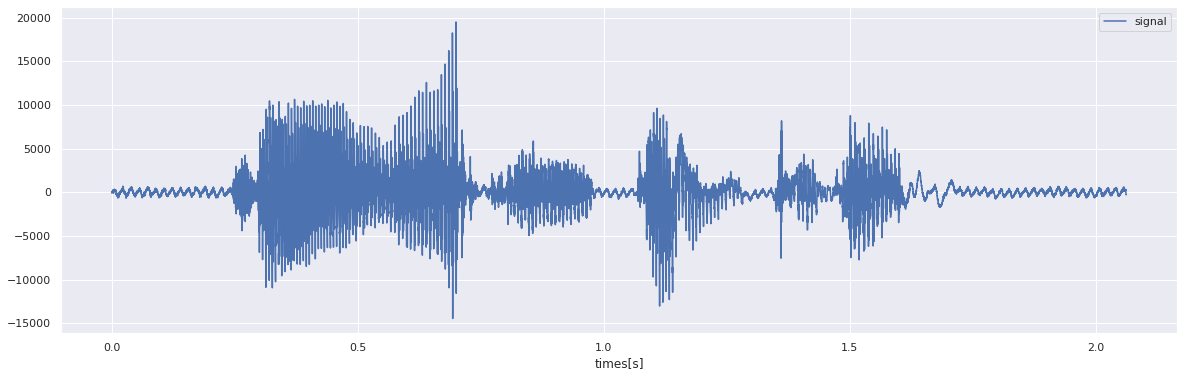

In [10]:
音声データ.plot()

## テキストデータ

In [11]:
with open('./data/sample.txt') as f:
    テキストデータ = f.read().rstrip()  # ファイル終端まで全て読んだデータを返す
テキストデータ

'きょーわいいてんきだ'

# APIを叩く

In [12]:
# 音素セグメンテーションapiを叩く
headers: dict = {'content-type': 'application/json'}
request_param: dict = {
    'filename': 'sample_01.wav',
    'wavedata': 音声データ.base64,
    'textdata': テキストデータ,
    'disableSilenceAtEnds': '0'
}
response = requests.post('http://localhost:8000', headers=headers, json=request_param)

# レスポンスの確認

In [13]:
response

<Response [201]>

In [14]:
response.json()

{'phonemes': [{'phoneme': 'silB',
   'wavedata': 'UklGRnYeAABXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACABAAZGF0YVIeAAAMAOH/6v/w/xEACwDA/xgAOQD//y0ADQDz/wMA9P8zAF4AJgAdAGgAbQBHAHoAXgD9/zsATQBbAHYAMQAPAE8AKwDr/zAAkgChAKgAmADEAAEB5QCAAEUAaABZAG8AzwAFAZEAKAA1AOD/s/+6/7D/MwBcANT/LgBzAC0AdwC7AMQAzQCOAIUAtABVAAMAiQDQAHgAlwDcAMYAvwB4AJcAngB3AJcAYgCoABkBOQFhATIB9wDWANIABwHxAKQAtgCeAN4A5wCXAM4AzwDeABUB6QDJALwAewB7ALwA/wAVAdIA1AC1AKUAtADJAPgAHAHSAK0A0ADaABgBBwEcAQYBBAHEALIAdAB8AHEAfADAANMAsADSAMsA///n/woA4P+u/7L/tP9d/xX/OP9c/xn/7v79/tr+Hv8r/wD/Zf8z//P+Ev9Q/0n/Hf+m/3P/PP9f/0//WP/s/ub+1v7X/uL+8f5c/yf/lP7h/rT+Mf5w/lT+YP6u/nz+dv7Y/sf+F/5o/mT+Jv5I/k/+Yf78/cv9Cf5r/ZL91f2z/aX9vP0+/iz+w/0k/o/+Z/5M/lP+RP5j/lz+Zv5n/kX+YP6C/lT+IP7+/QL+Bv6w/bX95v1D/rn+3f4L/xT/R/8g/xj/UP9o/6P/nf9q/3z/z/9U/yD/Vv/t/tP+M/9E/2//i/9Q/wr/5P74/i7/Zv9o/7X/y/8YACQA4v/5/z8AyP+2/0kA5v+A/5X/i//N/7P/Yf+e/8T/0/8WAP7/6/81AIkAWgAPAEwAMQABAJIAfgA0AC4APwBMAOT/DQBIAGAAuwB5AEQAZwBmAGYAJwD+/xwADAD7/2cAugDvAOgAAQE1AbEAiQDPAIIApgDMAP4ABQG5AO4AogBuAJ0AOwCNAN

# 音素データ wavファイルに書き出し

In [15]:
def write_binary(filepath: str, binary: bytes):
    ''' バイナリファイル書き出し

    Parameters
    --------------
    filepath: 書き出し先ファイルパス
    binary  : 書き出すバイナリ文字列(bytes)
    '''
    with open(filepath, mode='wb') as f:
        f.write(binary)

    return

-----------------------------------------
音素: silB
ファイル名: {'sample_01_silB_0us.wav'}
開始時間: 0.0
終了時間: 0.2425


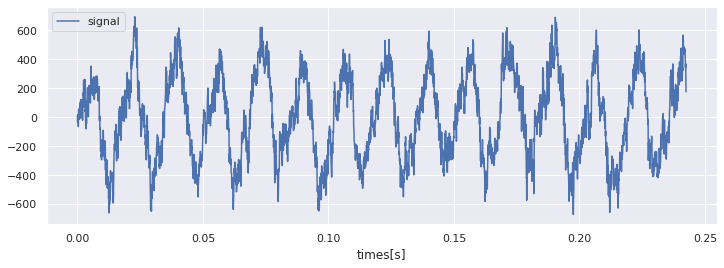

-----------------------------------------
音素: ky
ファイル名: {'sample_01_ky_242500us.wav'}
開始時間: 0.2425
終了時間: 0.3325


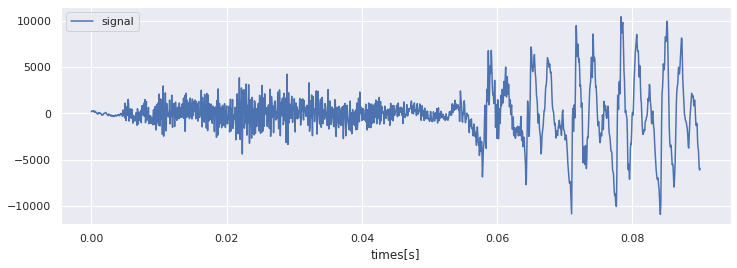

-----------------------------------------
音素: o:
ファイル名: {'sample_01_o:_332500us.wav'}
開始時間: 0.3325
終了時間: 0.5725


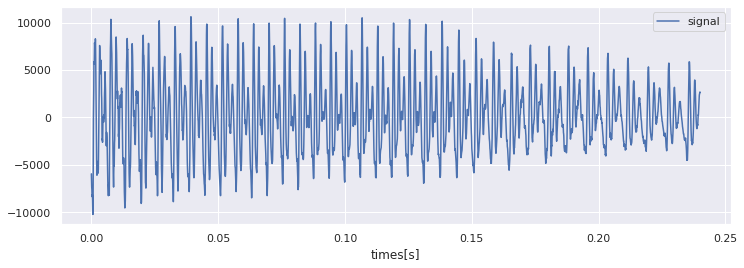

-----------------------------------------
音素: w
ファイル名: {'sample_01_w_572500us.wav'}
開始時間: 0.5725
終了時間: 0.6925


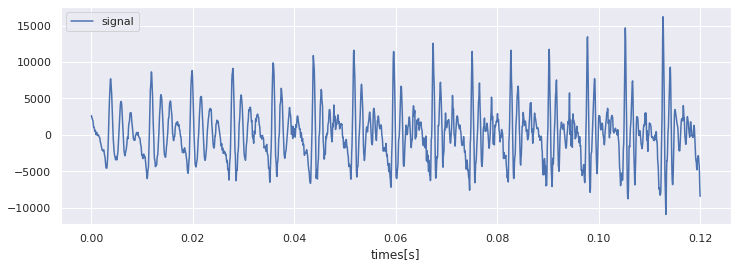

-----------------------------------------
音素: a
ファイル名: {'sample_01_a_692500us.wav'}
開始時間: 0.6925
終了時間: 0.7725


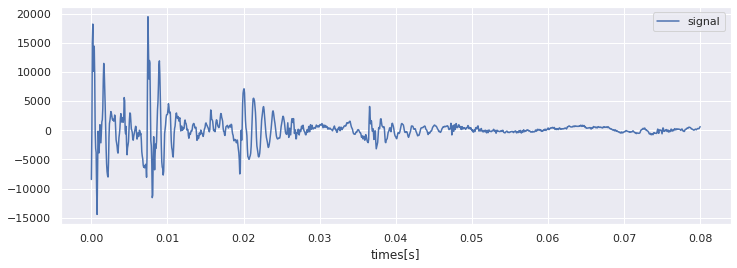

-----------------------------------------
音素: i
ファイル名: {'sample_01_i_772500us.wav'}
開始時間: 0.7725
終了時間: 0.8925


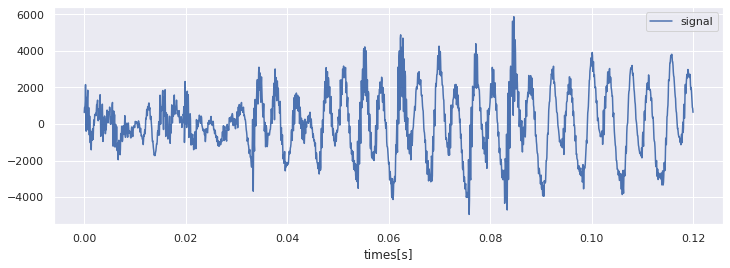

-----------------------------------------
音素: i
ファイル名: {'sample_01_i_892500us.wav'}
開始時間: 0.8925
終了時間: 0.9925


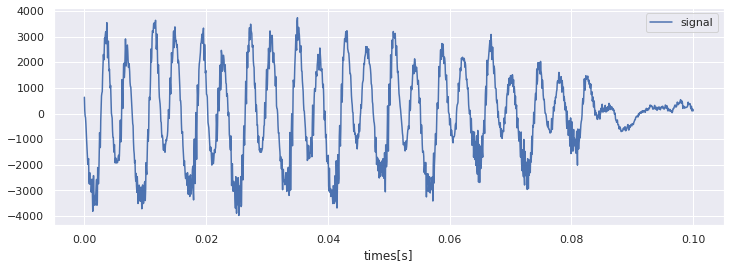

-----------------------------------------
音素: t
ファイル名: {'sample_01_t_992500us.wav'}
開始時間: 0.9925
終了時間: 1.0825


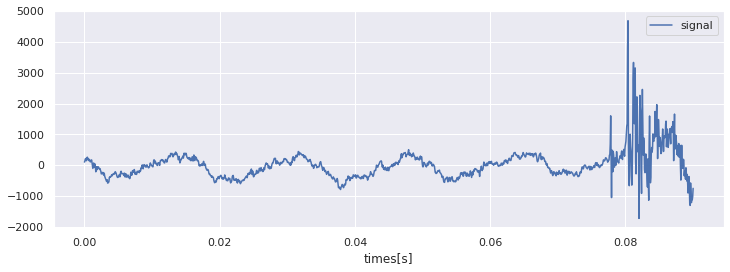

-----------------------------------------
音素: e
ファイル名: {'sample_01_e_1082500us.wav'}
開始時間: 1.0825
終了時間: 1.1825


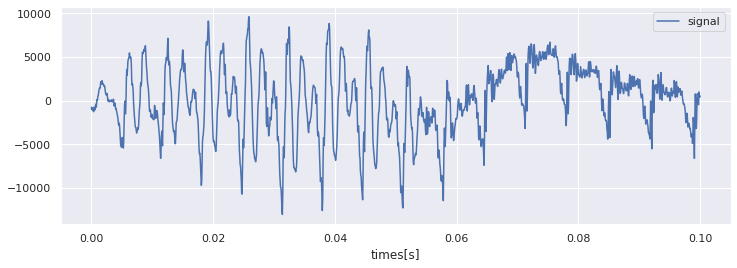

-----------------------------------------
音素: N
ファイル名: {'sample_01_N_1182500us.wav'}
開始時間: 1.1825
終了時間: 1.2825


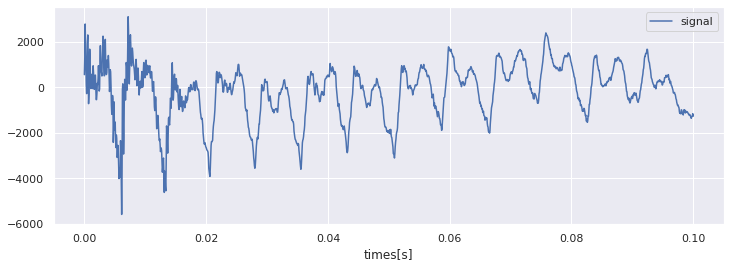

-----------------------------------------
音素: k
ファイル名: {'sample_01_k_1282500us.wav'}
開始時間: 1.2825
終了時間: 1.4025


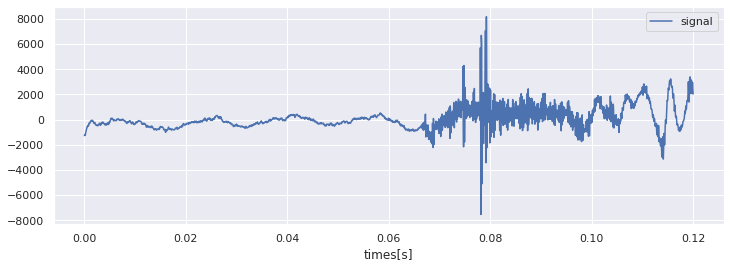

-----------------------------------------
音素: i
ファイル名: {'sample_01_i_1402500us.wav'}
開始時間: 1.4025
終了時間: 1.4525


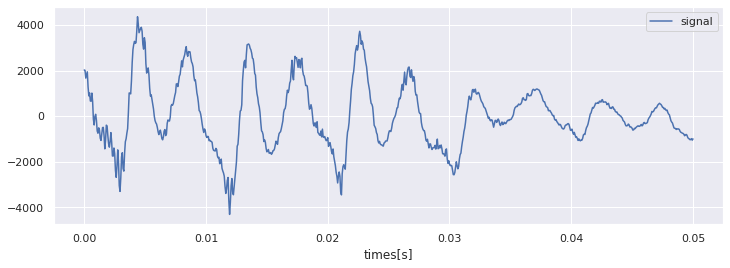

-----------------------------------------
音素: d
ファイル名: {'sample_01_d_1452500us.wav'}
開始時間: 1.4525
終了時間: 1.5125


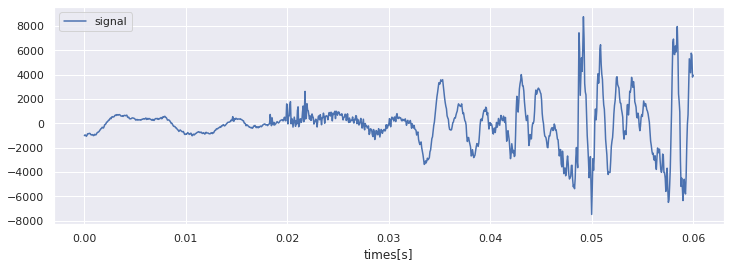

-----------------------------------------
音素: a
ファイル名: {'sample_01_a_1512500us.wav'}
開始時間: 1.5125
終了時間: 1.6125


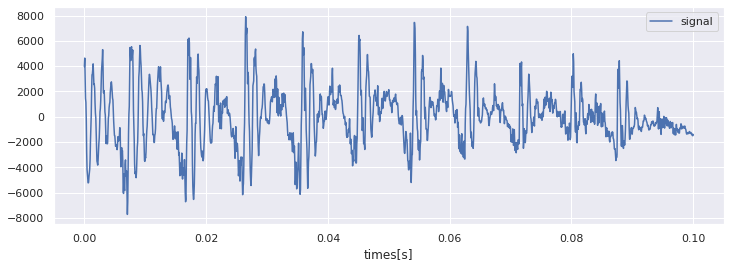

-----------------------------------------
音素: silE
ファイル名: {'sample_01_silE_1612500us.wav'}
開始時間: 1.6125
終了時間: 2.0525


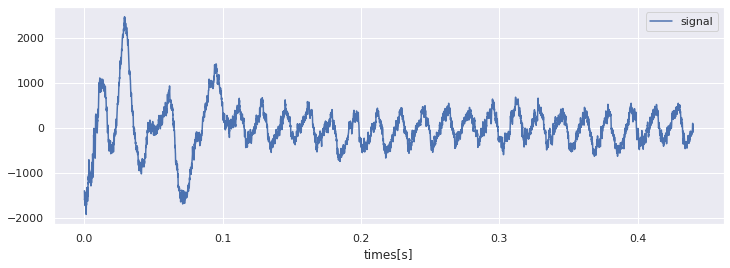

In [16]:
for 音素情報 in response.json()['phonemes']:
    print('-----------------------------------------')
    print('音素: {}'     .format(音素情報['phoneme']))
    print('ファイル名: {}' .format({音素情報['filename']}))
    print('開始時間: {}' .format(音素情報['startTime']))
    print('終了時間: {}' .format(音素情報['endTime']))
    
    # 音素base64形式をバイナリに変換
    音素バイナリ: bytes = base64.b64decode(音素情報['wavedata'].encode("UTF-8"))
    
    # 音素ファイル書き出し
    write_binary('phoneme/{}'.format(音素情報['filename']), 音素バイナリ)
    音素データ = Wavedata('phoneme/{}'.format(音素情報['filename']))
    音素データ.plot(figsize=(12, 4))

# Juliusのsegmentation-kitの出力ファイル書き出し

## labファイル

In [18]:
labファイルの内容 = response.json()['juliusLab']

with open('phoneme/sample.lab', mode='w') as f:
    f.write(labファイルの内容)

## logファイル

In [19]:
logファイルの内容 = response.json()['juliusLog']

with open('phoneme/sample.log', mode='w') as f:
    f.write(logファイルの内容)